# POC Loan Rates Forecast Model

# 1. Executive Summary

# 2. Model Information

# 3. Conceptual Soundness 

# 4. Model Development

## 4.1. Data Engineering

### 4.1.1. Data Collection

#### Setup

In [86]:
# System libraries
import glob

# ML libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from arch.unitroot import PhillipsPerron, DFGLS
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Load FRED Data

In [45]:
def merge_fred_csv_files(file_pattern):
    # Use glob to find all files matching the specified pattern
    file_list = glob.glob(file_pattern)

    # Initialize an empty list to store individual DataFrames
    dataframes = []

    # Iterate through each file in the file list
    for file in file_list:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')

        # Add the DataFrame to the list of DataFrames
        dataframes.append(df)

    # Merge all the DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dataframes, axis=1)

    return merged_df


In [46]:
file_pattern = '../datasets/fred/*.csv'
df = merge_fred_csv_files(file_pattern)
display(df)

,GDPC1,GS5,GS10,GS3,MORTGAGE30US,UNRATE,CPIAUCSL,FEDFUNDS,GDP
DATE,,,,,,,,,
1947-01-01,2034.450,NaN,NaN,NaN,NaN,NaN,21.48,NaN,243.164
1947-02-01,NaN,NaN,NaN,NaN,NaN,NaN,21.62,NaN,NaN
1947-03-01,NaN,NaN,NaN,NaN,NaN,NaN,22.00,NaN,NaN
1947-04-01,2029.024,NaN,NaN,NaN,NaN,NaN,22.00,NaN,245.968
1947-05-01,NaN,NaN,NaN,NaN,NaN,NaN,21.95,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-04-01,NaN,NaN,3.46,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,NaN,NaN,NaN,NaN,6.28,NaN,NaN,NaN,NaN
2023-04-13,NaN,NaN,NaN,NaN,6.27,NaN,NaN,NaN,NaN


Preselection of variables.

In [47]:
selected_cols = ['MORTGAGE30US', 'UNRATE', 'GS10', 'FEDFUNDS'] 
df = df[selected_cols]

Plot time series.

In [48]:
def plot_time_series(df, cols_to_plot=None, title=''):
    """
    Plot multiple time-series in the same axes using seaborn.

    :param df: DataFrame with time-series data
    :param cols_to_plot: List of column names to plot. If None, plot all columns in df.
    :param title: Title of the plot, default is ''
    """
    if cols_to_plot is None:
        cols_to_plot = df.columns.tolist()

    # Create a new DataFrame with the columns to plot
    plot_df = df[cols_to_plot]

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the time-series data
    plt.figure(figsize=(12, 6))
    for col in plot_df.columns:
        sns.lineplot(data=plot_df[col], label=col)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()


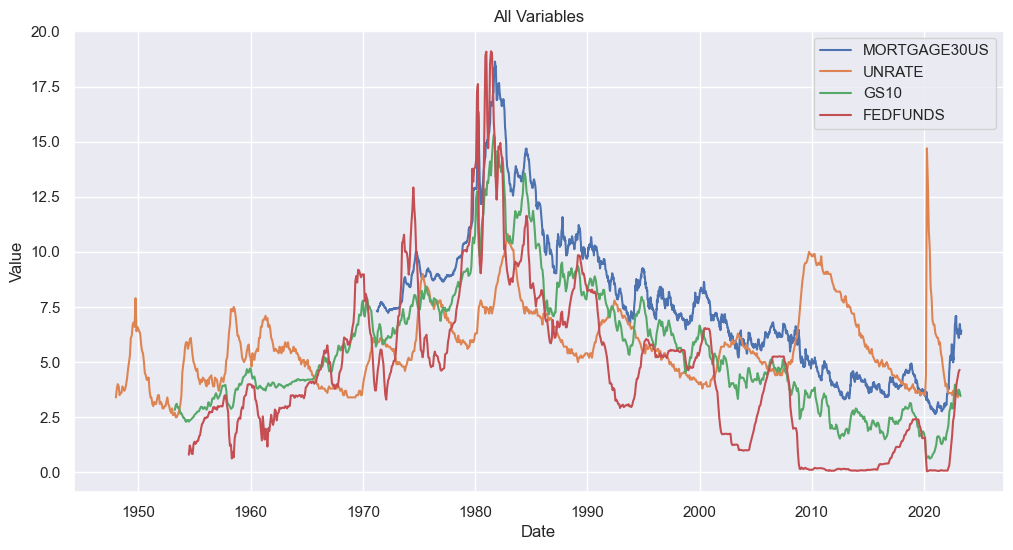

In [49]:
plot_time_series(df, title='All Variables')

### 4.1.2. Data Description

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3551 entries, 1947-01-01 to 2023-04-27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MORTGAGE30US  2718 non-null   float64
 1   UNRATE        903 non-null    float64
 2   GS10          841 non-null    float64
 3   FEDFUNDS      825 non-null    float64
dtypes: float64(4)
memory usage: 138.7 KB


### 4.1.3. Data Quality

#### Frequency of Series 

Distribution of frequencies in the data.

In [51]:
def plot_time_difference_frequency(df):
    # Calculate the time differences between consecutive entries
    time_diff = df.index.to_series().diff().dropna()

    # Convert the time differences to a suitable unit (e.g., days)
    time_diff_days = time_diff.dt.total_seconds() / (60 * 60 * 24)

    # Create a DataFrame with the time differences
    time_diff_df = pd.DataFrame({'Time Differences (Days)': time_diff_days})

    # Plot the frequency distribution of the time differences
    sns.histplot(data=time_diff_df, x='Time Differences (Days)', bins=50, kde=False)
    plt.xlabel('Time Differences (Days)')
    plt.ylabel('Frequency')
    plt.show()

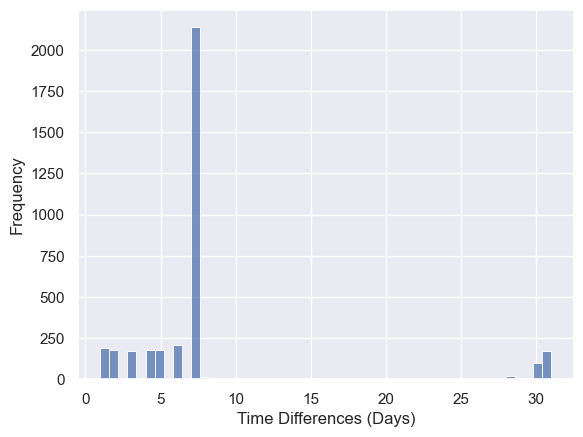

In [52]:
plot_time_difference_frequency(df)

Identify frequencies for each variable.

In [53]:
def identify_frequencies(df):
    """
    Identify the frequency of each series in the DataFrame.

    :param df: Time-series DataFrame
    :return: DataFrame with two columns: 'Variable' and 'Frequency'
    """
    frequencies = []
    for column in df.columns:
        series = df[column].dropna()
        if not series.empty:
            freq = pd.infer_freq(series.index)
            if freq == 'MS' or freq == 'M':
                label = 'Monthly'
            elif freq == 'Q':
                label = 'Quarterly'
            elif freq == 'A':
                label = 'Yearly'
            else:
                label = freq
        else:
            label = None

        frequencies.append({'Variable': column, 'Frequency': label})

    freq_df = pd.DataFrame(frequencies)

    return freq_df

In [54]:
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,None
1,UNRATE,Monthly
2,GS10,Monthly
3,FEDFUNDS,Monthly


Handling frequencies.

In [55]:
df = df.resample('MS').last()
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,Monthly
1,UNRATE,Monthly
2,GS10,Monthly
3,FEDFUNDS,Monthly


#### Missing Values

**Step 1: Identify Missing Values**

Total number of missing values.

In [56]:
def plot_missing_values_bar(df):
    """
    Plot a bar chart displaying the total number of missing values per variable (column) in a time-series DataFrame using seaborn.
    
    :param df: Time-series DataFrame
    """
    # Calculate the total number of missing values per column
    missing_values = df.isnull().sum()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Variables (Columns)')
    plt.ylabel('Number of Missing Values')
    plt.title('Total Number of Missing Values per Variable')
    plt.show()

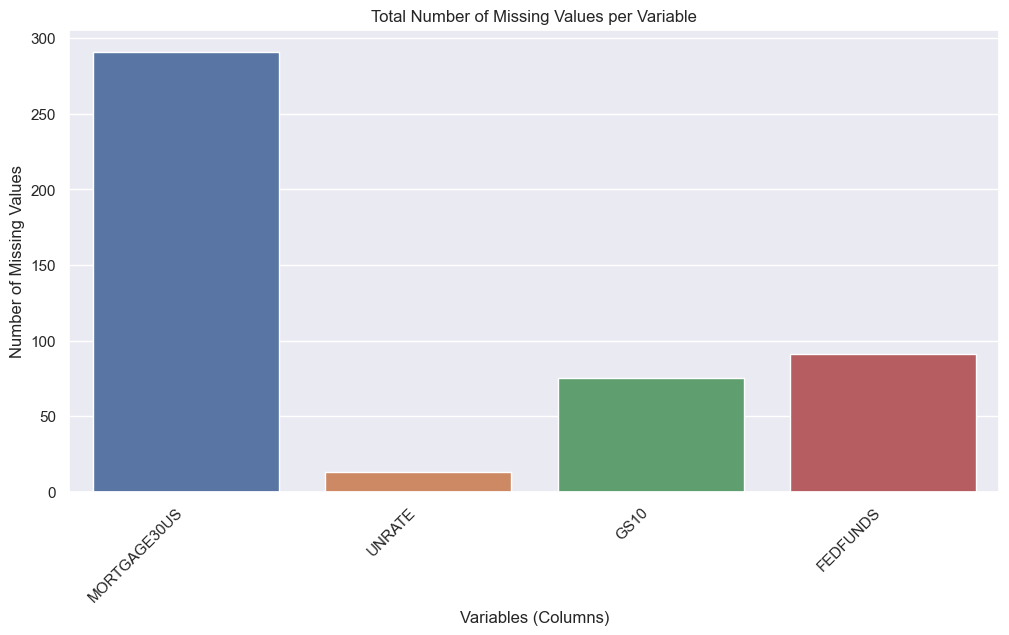

In [57]:
plot_missing_values_bar(df)

Heatmap of missing values.

In [58]:
def plot_missing_values_heatmap(df, start_year=None, end_year=None):
    """
    Plot a heatmap of missing values with actual years in rows using seaborn.

    :param df: Time-series DataFrame
    :param start_year: Start year for zooming in, defaults to None
    :param end_year: End year for zooming in, defaults to None
    """
    # Filter the DataFrame based on the specified start_year and end_year
    if start_year:
        df = df[df.index.year >= start_year]
    if end_year:
        df = df[df.index.year <= end_year]

    # Create a boolean mask for missing values
    missing_mask = df.isnull()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(missing_mask.T, cmap='viridis', cbar=False, xticklabels=False)

    # Add actual years on the x-axis
    years = df.index.year.unique()
    xticks = [df.index.get_loc(df.index[df.index.year == year][0]) for year in years]
    plt.xticks(xticks, years, rotation=45, ha='right')

    plt.ylabel('Columns')
    plt.xlabel('Rows (Years)')
    plt.title('Missing Values Heatmap with Actual Years in Rows')
    plt.show()

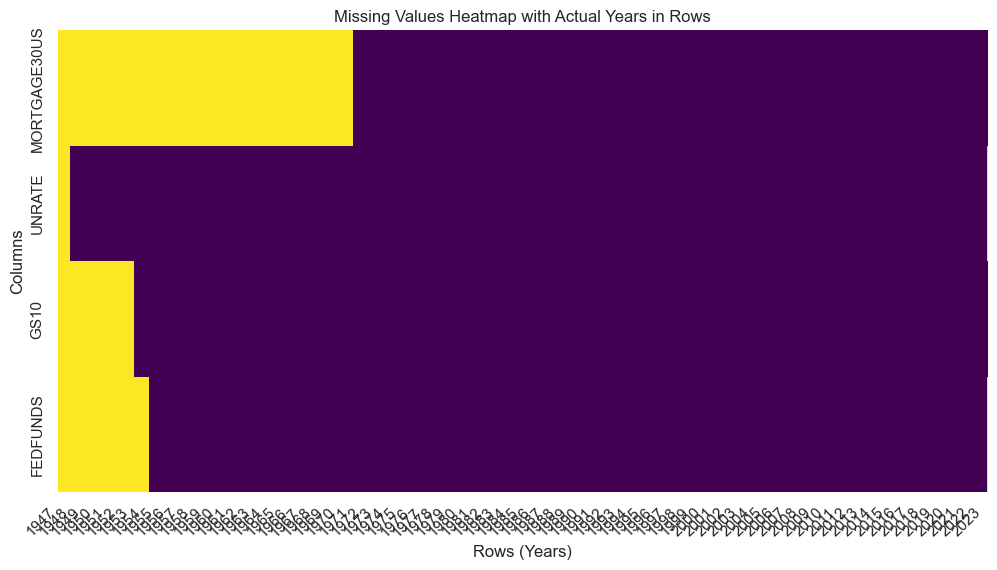

In [59]:
plot_missing_values_heatmap(df)

**Step 2: Handling Missing Values**

Drop missing values.

In [60]:
df = df.dropna()

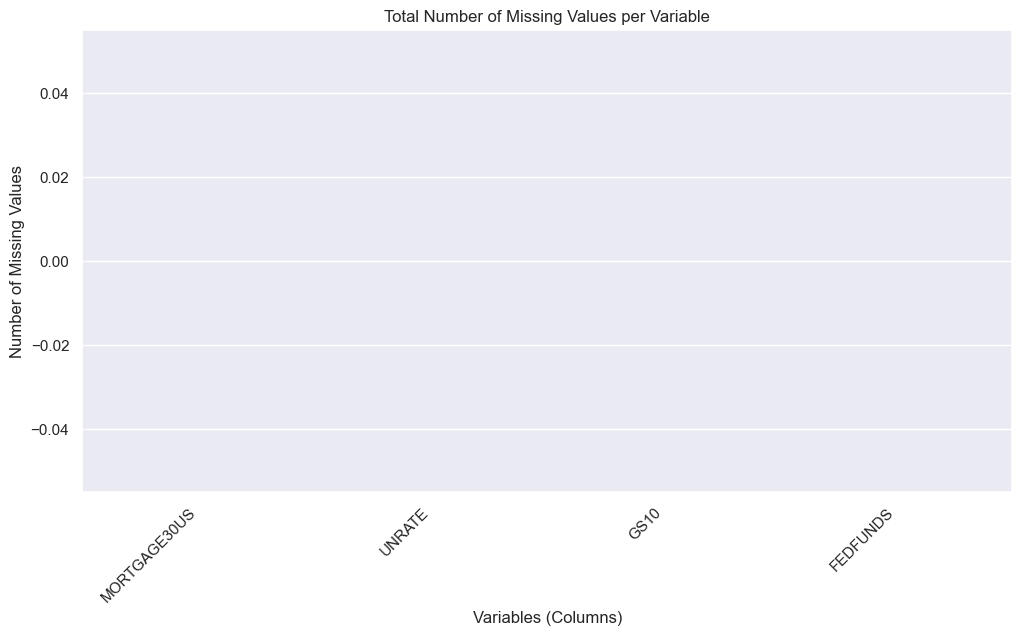

In [61]:
plot_missing_values_bar(df)

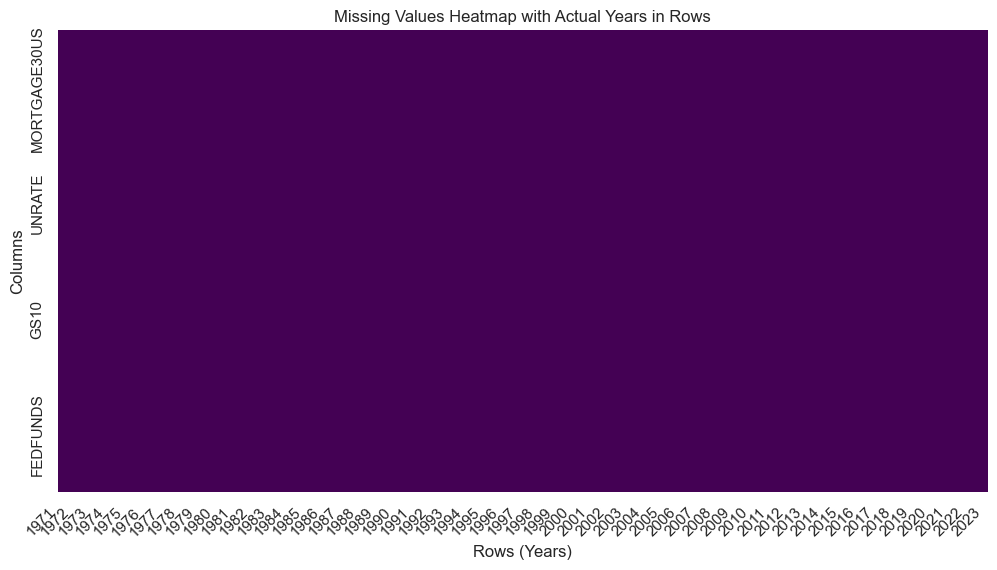

In [62]:
plot_missing_values_heatmap(df)

#### Outliers

**Step 1: Identify Outliers**

**Step 2: Handling Outliers**

## 4.2. Exploratory Data Analysis

### 4.2.1. Univariate Analysis

#### Visual Inspection

Line plots.

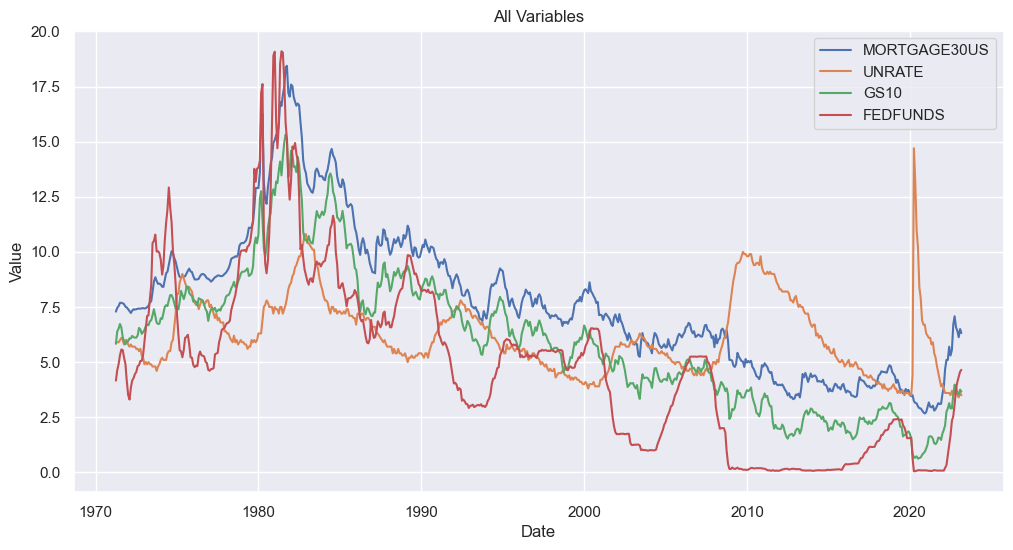

In [63]:
plot_time_series(df, title='All Variables')

#### Seasonality 

**Step 1: Compute Seasonal Decomposition**

In [64]:
def compute_seasonal_decomposition(data, model='additive'):
    """
    Compute seasonal decomposition for all time-series in a DataFrame and store all the components in a new DataFrame.
    
    :param data: DataFrame with time-series data
    :param period: Number of observations in each seasonal period
    :return: DataFrame with seasonal, trend, and residual components for all time-series in the input DataFrame
    """
    # Initialize an empty DataFrame to store the components for each time-series
    decomp_df = pd.DataFrame()

    # Loop over each column in the input DataFrame and perform seasonal decomposition
    for col in data.columns:
        res = seasonal_decompose(data[col], model=model)
        decomp_df[f'{col}_seasonal'] = res.seasonal
        decomp_df[f'{col}_trend'] = res.trend
        decomp_df[f'{col}_residual'] = res.resid

    # Set the index of the decomposed DataFrame to be the same as the input DataFrame
    decomp_df.index = data.index

    return decomp_df


In [65]:
decomp_df = compute_seasonal_decomposition(df)

**Step 2: Visualize Seasonal Decomposition**

In [66]:
def plot_seasonal_components(decomp_df):
    """
    Plot all seasonal, trend, and residual components for each variable in a DataFrame.
    
    :param decomp_df: DataFrame with seasonal, trend, and residual components for each variable
    """
    # Initialize a figure with subplots for each variable and component
    fig, axs = plt.subplots(nrows=len(decomp_df.columns) // 3, ncols=3, figsize=(12, 4 * (len(decomp_df.columns) // 3)))

    # Loop over each variable in the input DataFrame and plot the seasonal, trend, and residual components
    for i, col in enumerate(decomp_df.columns[::3]):
        axs[i, 0].plot(decomp_df.index, decomp_df[f'{col}'])
        axs[i, 0].set_title(f'Seasonal: {col[:-9]}')
        axs[i, 1].plot(decomp_df.index, decomp_df[f'{col[:-9]}_trend'])
        axs[i, 1].set_title(f'Trend: {col[:-9]}')
        axs[i, 2].plot(decomp_df.index, decomp_df[f'{col[:-9]}_residual'])
        axs[i, 2].set_title(f'Residual: {col[:-9]}')

    # Set the figure title
    fig.suptitle('Seasonal Decomposition', fontsize=16)

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()

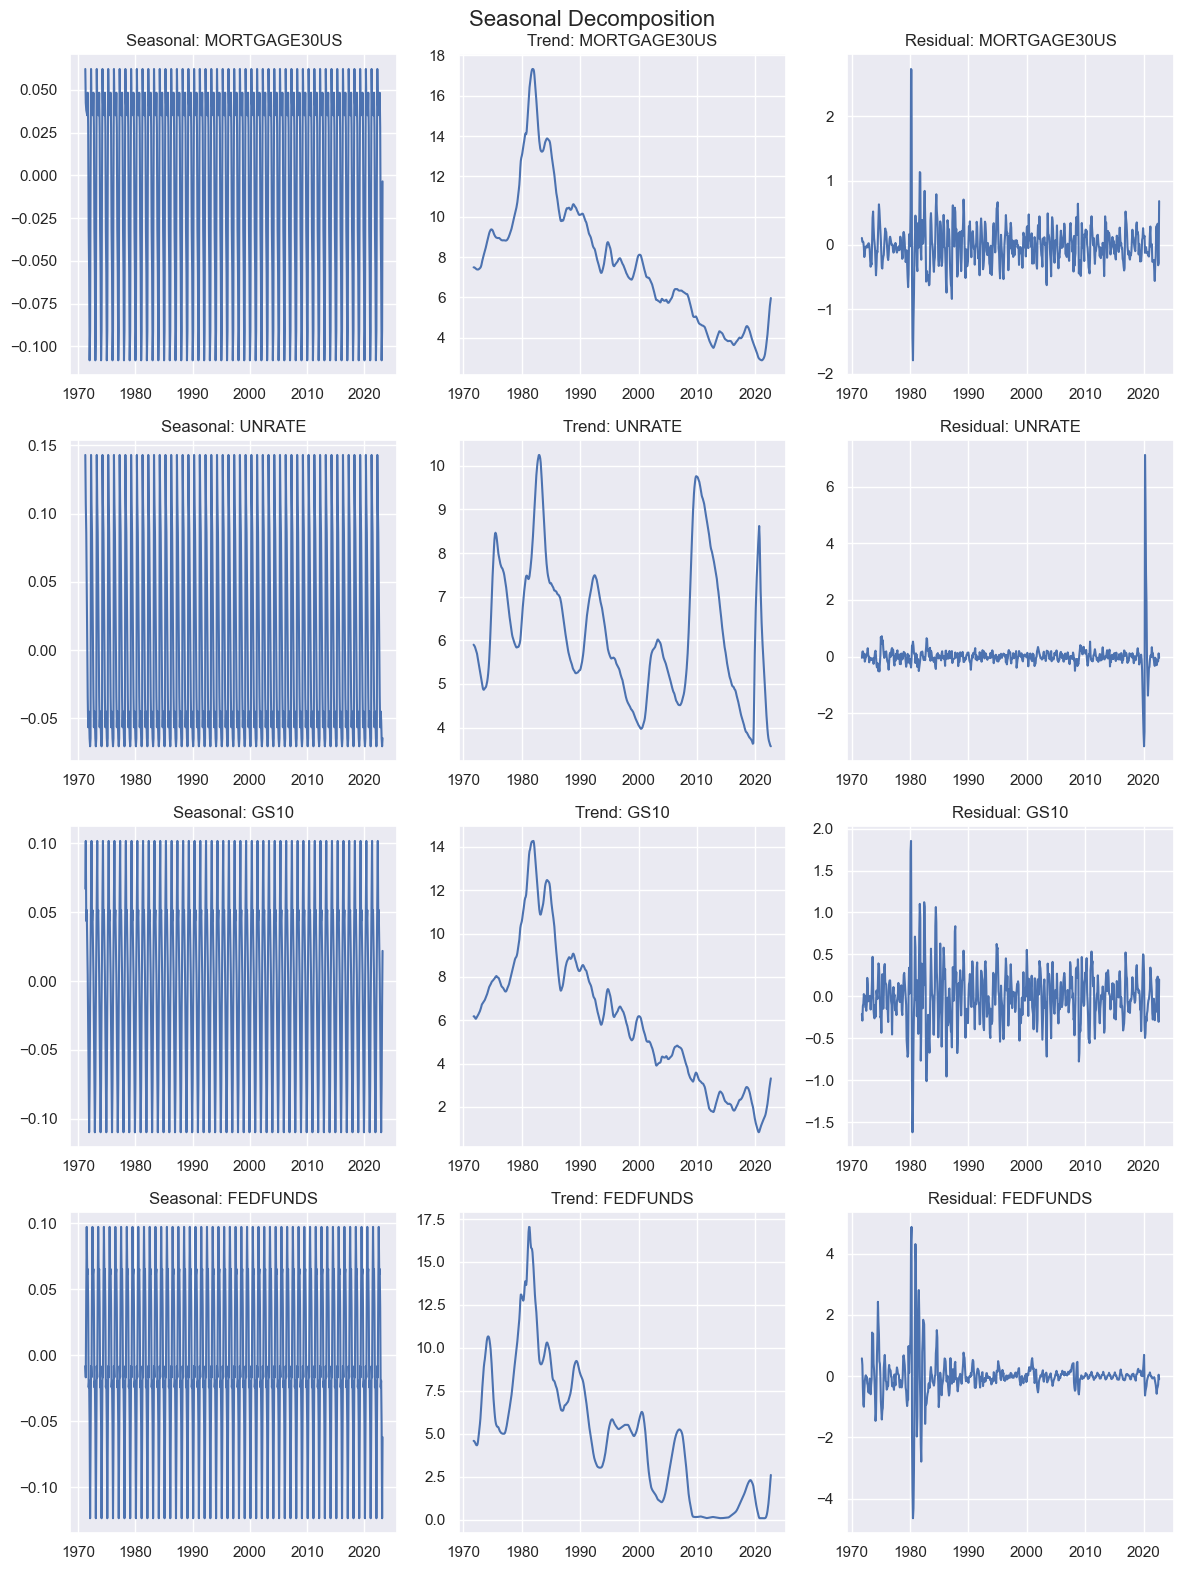

In [67]:
plot_seasonal_components(decomp_df)

**Step 3: Residual Analysis**

#### Stationarity

**Step 1: Compute Unit Root Tests on Levels**

In [68]:
def test_stationarity(data, threshold=0.05):
    """
    Perform multiple stationarity tests on each time series in a DataFrame.
    
    :param data: DataFrame with time-series data
    :return: DataFrame with test results (Variable, Test, p-value, Threshold, Pass/Fail, Decision)
    """
    # Initialize an empty DataFrame to store the test results
    test_results = pd.DataFrame(columns=['Variable', 'Test', 'p-value', 'Threshold', 'Pass/Fail', 'Decision'])

    # Loop over each column in the input DataFrame and perform stationarity tests
    for col in data.columns:
        # Perform the ADF test
        adf_result = adfuller(data[col], autolag='AIC')
        adf_pvalue = adf_result[1]
        adf_pass_fail = adf_pvalue < threshold
        adf_decision = 'Stationary' if adf_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'ADF',
            'p-value': adf_pvalue,
            'Threshold': threshold,
            'Pass/Fail': adf_pass_fail,
            'Decision': adf_decision
        }, ignore_index=True)

        # Perform the KPSS test
        kpss_result = kpss(data[col], regression='c', nlags='auto')
        kpss_pvalue = kpss_result[1]
        kpss_pass_fail = kpss_pvalue > threshold
        kpss_decision = 'Stationary' if kpss_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'KPSS',
            'p-value': kpss_pvalue,
            'Threshold': threshold,
            'Pass/Fail': kpss_pass_fail,
            'Decision': kpss_decision
        }, ignore_index=True)

        # Perform the Phillips-Perron test
        pp_result = PhillipsPerron(data[col], trend='ct')
        pp_pvalue = pp_result.pvalue
        pp_threshold = threshold
        pp_pass_fail = pp_pvalue < pp_threshold
        pp_decision = 'Stationary' if pp_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'PhillipsPerron',
            'p-value': pp_pvalue,
            'Threshold': pp_threshold,
            'Pass/Fail': pp_pass_fail,
            'Decision': pp_decision
        }, ignore_index=True)

        # Perform the DF-GLS test
        dfgls_result = DFGLS(data[col], trend='ct')
        dfgls_pvalue = dfgls_result.pvalue
        dfgls_threshold = threshold
        dfgls_pass_fail = dfgls_pvalue < dfgls_threshold
        dfgls_decision = 'Stationary' if dfgls_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'DFGLS',
            'p-value': dfgls_pvalue,
            'Threshold': dfgls_threshold,
            'Pass/Fail': dfgls_pass_fail,
            'Decision': dfgls_decision
        }, ignore_index=True)

    return test_results


In [69]:
test_stationarity(df)

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,Variable,Test,p-value,Threshold,Pass/Fail,Decision
0,MORTGAGE30US,ADF,0.671948,0.05,False,Non-stationary
1,MORTGAGE30US,KPSS,0.010000,0.05,False,Non-stationary
2,MORTGAGE30US,PhillipsPerron,0.266671,0.05,False,Non-stationary
3,MORTGAGE30US,DFGLS,0.633164,0.05,False,Non-stationary
4,UNRATE,ADF,0.019395,0.05,True,Stationary
5,UNRATE,KPSS,0.070375,0.05,True,Stationary
6,UNRATE,PhillipsPerron,0.023946,0.05,True,Stationary
7,UNRATE,DFGLS,0.017522,0.05,True,Stationary
8,GS10,ADF,0.709954,0.05,False,Non-stationary
9,GS10,KPSS,0.010000,0.05,False,Non-stationary


**Step 2: Compute Unit Root Tests on First Difference**

Take first difference. 

In [70]:
df_diff = df.diff().dropna()

In [71]:
test_stationarity(df_diff)

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/

,Variable,Test,p-value,Threshold,Pass/Fail,Decision
0,MORTGAGE30US,ADF,2.156453e-30,0.05,True,Stationary
1,MORTGAGE30US,KPSS,1.000000e-01,0.05,True,Stationary
2,MORTGAGE30US,PhillipsPerron,0.000000e+00,0.05,True,Stationary
3,MORTGAGE30US,DFGLS,0.000000e+00,0.05,True,Stationary
4,UNRATE,ADF,5.611475e-26,0.05,True,Stationary
5,UNRATE,KPSS,1.000000e-01,0.05,True,Stationary
6,UNRATE,PhillipsPerron,0.000000e+00,0.05,True,Stationary
7,UNRATE,DFGLS,0.000000e+00,0.05,True,Stationary
8,GS10,ADF,2.036674e-09,0.05,True,Stationary
9,GS10,KPSS,1.000000e-01,0.05,True,Stationary


#### AR Analysis

**Step 1: Calculate AR Orders**

In [72]:
def calculate_ar_orders(dataset, max_order=3):
    """
    This function calculates the autoregressive order of all time series in a dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset containing the time series.
    max_order (int): The maximum order to consider for the autoregressive models.
    
    Returns:
    pd.DataFrame: A table with the autoregressive order, AIC, and BIC for orders 0 up to max_order.
    """
    # Initialize an empty list to store the results
    results = []

    # Iterate over each column (time series) in the dataset
    for col in dataset.columns:
        time_series = dataset[col]
        
        # Test for stationarity using Augmented Dickey-Fuller test
        adf_result = adfuller(time_series)
        if adf_result[1] > 0.05:
            time_series = time_series.diff().dropna()  # Apply first difference to make the series stationary
        
        # Test different autoregressive orders and store the AIC and BIC values
        for order in range(max_order + 1):
            model = AutoReg(time_series, lags=order, old_names=False)
            result = model.fit()
            
            # Add the current time series, order, AIC, and BIC to the results list
            results.append({'Variable': col, 'AR order': order, 'AIC': result.aic, 'BIC': result.bic})

    # Convert the results list to a DataFrame and return it
    return pd.DataFrame(results)

In [73]:
calculate_ar_orders(df_diff)

,Variable,AR order,AIC,BIC
0,MORTGAGE30US,0,291.177506,300.046599
1,MORTGAGE30US,1,246.637029,259.935849
2,MORTGAGE30US,2,223.310101,241.035426
3,MORTGAGE30US,3,225.331792,247.480389
4,UNRATE,0,835.075578,843.944671
5,UNRATE,1,835.941726,849.240546
6,UNRATE,2,833.607234,851.332559
7,UNRATE,3,835.222318,857.370915
8,GS10,0,243.604950,252.474043
9,GS10,1,179.889575,193.188396


**Step 2: Selection of AR Order**

#### MA Analysis

**Step 1: Calculate MA Orders**

In [74]:
def calculate_ma_orders(dataset, max_order=3):
    """
    This function calculates the moving average order of all time series in a dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset containing the time series.
    max_order (int): The maximum order to consider for the moving average models.
    
    Returns:
    pd.DataFrame: A table with the moving average order, AIC, and BIC for orders 0 up to max_order.
    """
    # Initialize an empty list to store the results
    results = []

    # Iterate over each column (time series) in the dataset
    for col in dataset.columns:
        time_series = dataset[col]
        
        # Test for stationarity using Augmented Dickey-Fuller test
        adf_result = adfuller(time_series)
        if adf_result[1] > 0.05:
            time_series = time_series.diff().dropna()  # Apply first difference to make the series stationary
        
        # Test different moving average orders and store the AIC and BIC values
        for order in range(max_order + 1):
            model = ARIMA(time_series, order=(0, 0, order))
            result = model.fit()
            
            # Add the current time series, order, AIC, and BIC to the results list
            results.append({'Variable': col, 'MA order': order, 'AIC': result.aic, 'BIC': result.bic})

    # Convert the results list to a DataFrame and return it
    return pd.DataFrame(results)

In [75]:
calculate_ma_orders(df_diff)

,Variable,MA order,AIC,BIC
0,MORTGAGE30US,0,291.177507,300.046600
1,MORTGAGE30US,1,228.313186,241.616825
2,MORTGAGE30US,2,227.394618,245.132804
3,MORTGAGE30US,3,225.782939,247.955672
4,UNRATE,0,835.075578,843.944671
5,UNRATE,1,836.126269,849.429909
6,UNRATE,2,833.512857,851.251043
7,UNRATE,3,835.509496,857.682228
8,GS10,0,243.604950,252.474043
9,GS10,1,155.604373,168.908013


**Step 2: Selection of MA Order**

### 4.2.2. Multivariate Analysis

#### Correlations

**Step 1: Compute Correlation Matrix on Levels**

In [76]:
def plot_corr_heatmap(df):
    # Compute correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

    # Set plot title
    plt.title('Correlation Matrix Heatmap')

    # Show plot
    plt.show()


Corrrelations across Levels.

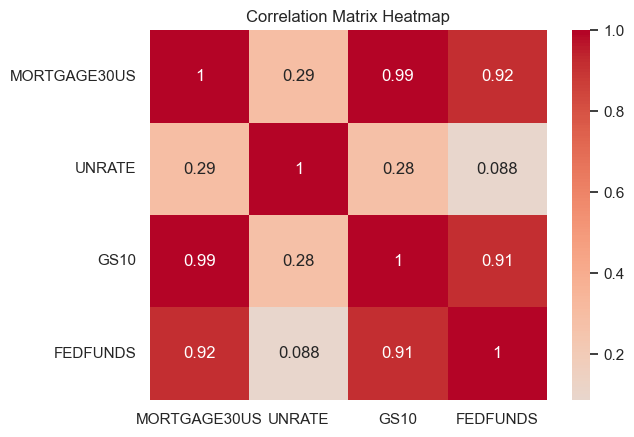

In [77]:
plot_corr_heatmap(df)

**Step 2: Compute Correlation Matrix on First Difference**

Correlations across First Differences.

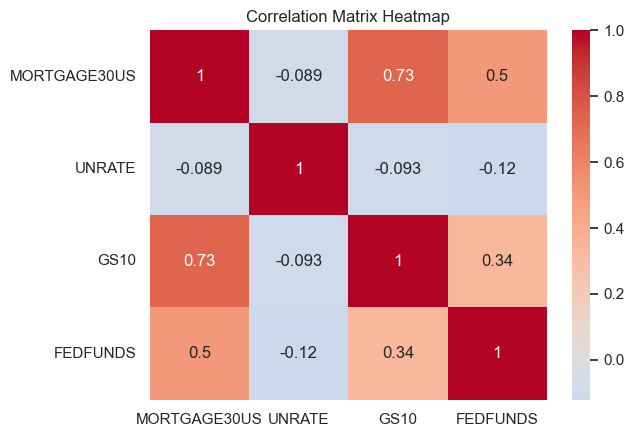

In [78]:
plot_corr_heatmap(df_diff)

**Step 3: Reasoning**

#### Scatter Plots

**Step 1: Compute Scatter Plots on Levels**

In [79]:
def plot_scatter_pairs(df):
    # Compute pairwise scatter plots
    sns.pairplot(df, kind='scatter')

    # Show plot
    plt.show()

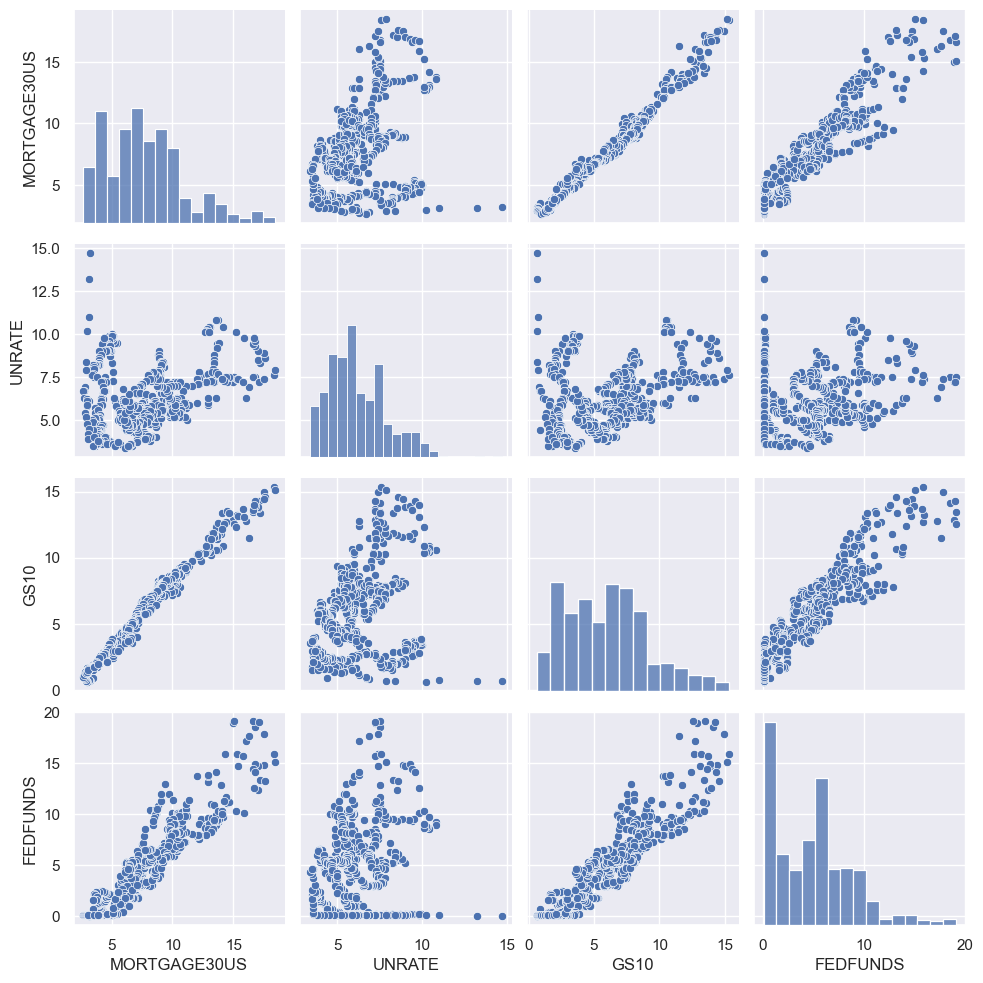

In [80]:
plot_scatter_pairs(df)

**Step 2: Compute Scatter Plots on First Difference**

Compute first difference.

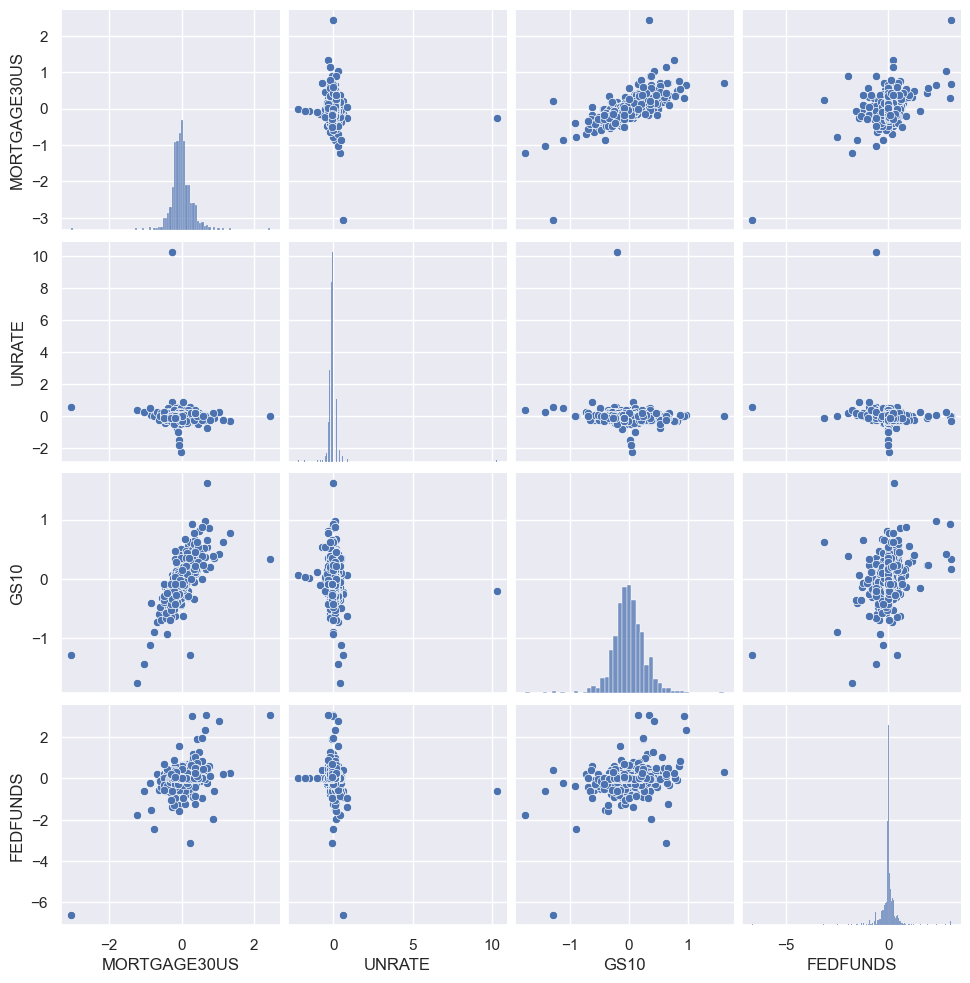

In [81]:
plot_scatter_pairs(df_diff)

**Step 3: Reasoning**

#### Lag Analsyis

**Step 1: Compute Correlations at Multiple Lags**

In [84]:
def plot_heatmap_correlations(df, target_col, independent_vars, num_lags=10):
    """
    Calculate the correlation between the target variable and the lags of independent variables in the dataset,
    and plot a heatmap of these correlations.
    :param df: DataFrame containing the target variable and independent variables of interest
    :param target_col: Column name of the target variable in the DataFrame
    :param independent_vars: List of column names of the independent variables in the DataFrame
    :param num_lags: Number of lags to calculate (default is 10)
    """

    correlations = np.zeros((len(independent_vars), num_lags + 1))

    for i, ind_var_col in enumerate(independent_vars):
        for lag in range(num_lags + 1):
            # Create a new DataFrame with the original and lagged variable
            temp_df = pd.DataFrame({target_col: df[target_col],
                                    f'{ind_var_col}_lag{lag}': df[ind_var_col].shift(lag)})

            # Drop NaN rows
            temp_df = temp_df.dropna()

            # Calculate the correlation between the target variable and the lagged independent variable
            corr = temp_df[target_col].corr(temp_df[f'{ind_var_col}_lag{lag}'])

            # Store the correlation in the correlations matrix
            correlations[i, lag] = corr

    # Create a DataFrame with the correlations matrix
    correlation_df = pd.DataFrame(correlations, columns=[f'lag_{i}' for i in range(num_lags + 1)], index=independent_vars)

    # Plot the heatmap
    plt.figure(figsize=(12, 3))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Heatmap of Correlations between Target Variable and Lags of Independent Variables')
    plt.xlabel('Lags')
    plt.ylabel('Independent Variables')
    plt.show()


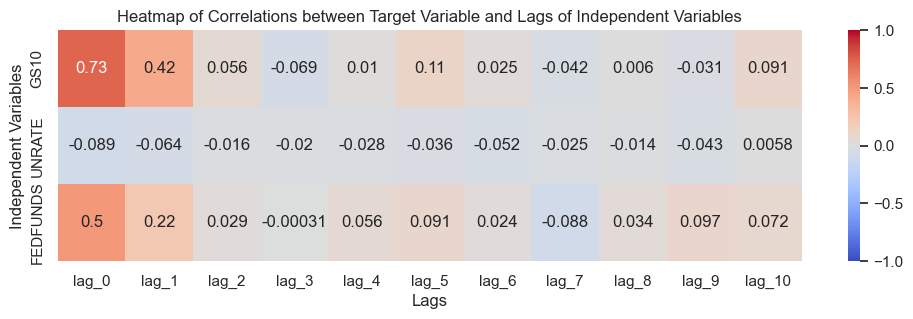

In [85]:
target_var = 'MORTGAGE30US'
independent_vars = ['GS10', 'UNRATE', 'FEDFUNDS']
plot_heatmap_correlations(df_diff, target_col=target_var, independent_vars=independent_vars, num_lags=10)

**Step 2: Reasoning**

### 4.2.3. Feature Selection

## 4.3. Model Methodology

## 4.4. Training Data

## 4.5. Model Evaluation

### Model 1: Loan Rates and FEDFUNDS

**Step 1: Fit Model**

In [93]:
# Add the independent variables with no intercept
X = df_diff['FEDFUNDS']

# Define the dependent variable 
y = df_diff['MORTGAGE30US']

# Fit the linear regression model
model_1 = sm.OLS(y, X).fit()

# Display the model summary
print(model_1.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.254
Model:                            OLS   Adj. R-squared (uncentered):              0.253
Method:                 Least Squares   F-statistic:                              212.3
Date:                Wed, 03 May 2023   Prob (F-statistic):                    1.37e-41
Time:                        09:55:23   Log-Likelihood:                         -52.125
No. Observations:                 623   AIC:                                      106.3
Df Residuals:                     622   BIC:                                      110.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Step 2: Reasoning**

### Model 2: Loan Rates, constant and FEDFUNDS

**Step 1: Fit Model**

In [98]:
# Add a constant to the independent variables for the linear regression model
X = sm.add_constant(df_diff['FEDFUNDS'])

# Define the dependent variable 
y = df_diff['MORTGAGE30US']

# Fit the linear regression model
model_2 = sm.OLS(y, X).fit()

# Display the model summary
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:           MORTGAGE30US   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     212.0
Date:                Wed, 03 May 2023   Prob (F-statistic):           1.58e-41
Time:                        10:00:18   Log-Likelihood:                -52.111
No. Observations:                 623   AIC:                             108.2
Df Residuals:                     621   BIC:                             117.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.011     -0.169      0.8

**Step 2: Reasoning**

### Model 3: Loan Rates and GS10

In [99]:
# Add a constant to the independent variables for the linear regression model
X = df_diff['GS10']

# Define the dependent variable 
y = df_diff['MORTGAGE30US']

# Fit the linear regression model
model_3 = sm.OLS(y, X).fit()

# Display the model summary
print(model_3.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.530
Model:                            OLS   Adj. R-squared (uncentered):              0.529
Method:                 Least Squares   F-statistic:                              700.5
Date:                Wed, 03 May 2023   Prob (F-statistic):                   5.68e-104
Time:                        10:00:47   Log-Likelihood:                          91.386
No. Observations:                 623   AIC:                                     -180.8
Df Residuals:                     622   BIC:                                     -176.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Model 4: Loan Rates, FEDFUNDS and GS10

**Step 1: Fit Model**

In [101]:
# Add a constant to the independent variables for the linear regression model
X = df_diff[['GS10', 'FEDFUNDS']]

# Define the dependent variable 
y = df_diff['MORTGAGE30US']

# Fit the linear regression model
model_4 = sm.OLS(y, X).fit()

# Display the model summary
print(model_4.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.606
Model:                            OLS   Adj. R-squared (uncentered):              0.604
Method:                 Least Squares   F-statistic:                              476.7
Date:                Wed, 03 May 2023   Prob (F-statistic):                   3.55e-126
Time:                        10:05:11   Log-Likelihood:                          146.19
No. Observations:                 623   AIC:                                     -288.4
Df Residuals:                     621   BIC:                                     -279.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Step 2: Reasoning**

### Model 5: Loan Rates, FEDFUNDS, GS10 and UNRATE

**Step 1: Fit Model**

In [103]:
# Add a constant to the independent variables for the linear regression model
X = df_diff[['GS10', 'FEDFUNDS', 'UNRATE']]

# Define the dependent variable 
y = df_diff['MORTGAGE30US']

# Fit the linear regression model
model_5 = sm.OLS(y, X).fit()

# Display the model summary
print(model_5.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.606
Model:                            OLS   Adj. R-squared (uncentered):              0.604
Method:                 Least Squares   F-statistic:                              317.3
Date:                Wed, 03 May 2023   Prob (F-statistic):                   8.57e-125
Time:                        10:08:18   Log-Likelihood:                          146.21
No. Observations:                 623   AIC:                                     -286.4
Df Residuals:                     620   BIC:                                     -273.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## 4.6. Model Evaluation